<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/transfer_learning_in_tensor_flow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 2 fine tuning

In the previous notebook, we coovered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning called fine tuning.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Check if you are using a gpu

!nvidia-smi

Sat May 25 14:41:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   36C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebook, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your noteboks (or elsewhere).

We've done this for some of the functions we've used previously here: [herlper functions](https://raw.githubusercontent.com/miller00315/tensorflow-deep-learning/main/extras/helper_functions.py)

In [3]:
!wget https://raw.githubusercontent.com/miller00315/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-25 14:41:38--  https://raw.githubusercontent.com/miller00315/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-25 14:41:39 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're runnign this notebook in Google Colab , when it times out collab will delete `helper_functions.py`, so you'll have to redownload it if you want to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretained models with tf.keras.application and apply then to our own problem.

In [5]:
# Get 10% of trained data of 10 classes of food

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-05-25 14:41:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   179MB/s    in 0.9s    

2024-05-25 14:41:44 (179 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dat set
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [7]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
input_shape = (224, 224, 3)

## Model 0: Building a transfer training model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models. [Keras functional](https://www.tensorflow.org/guide/keras/functional_api)

In [12]:
# 1. Create the base model tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

24274472/24274472 [==============================] - 0s 0us/step


In [13]:
# 2. Freeze ther basemodel (sot the underlaying pre-trained patterns aren't updated during training)

base_model.trainable = False

In [14]:
# 3. Create inputs into our model

inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,), name="input_layer")

In [ ]:
# 4. If using ResNet50v2 you will need to normalize inputs (yout don't need have for EfficienteNet1)

#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

In [15]:
# 5. Pass the inputs ro the base model
x = base_model(inputs)

print(f"Shape after passing through base model: {x.shape}")

Shape after passing through base model: (None, 7, 7, 1280)


In [16]:
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

Shape after GlobalAveragePooling2D: (None, 1280)


In [17]:
# 7. Create the output activation layer

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

In [18]:
# 8. Combine the inputs with the outputs in to a model

model_0 = tf.keras.Model(inputs, outputs)

In [19]:
# 9. Compile the model

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [20]:
# 10. Fit the model and save its history

history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240525-144223
Epoch 1/5
24/24 [==============================] - 14s 137ms/step - loss: 1.8894 - accuracy: 0.3960 - val_loss: 1.3126 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 1s 45ms/step - loss: 1.1550 - accuracy: 0.7547 - val_loss: 0.8900 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 1s 45ms/step - loss: 0.8427 - accuracy: 0.8200 - val_loss: 0.6971 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 1s 46ms/step - loss: 0.6873 - accuracy: 0.8440 - val_loss: 0.6054 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 1s 47ms/step - loss: 0.5908 - accuracy: 0.8640 - val_loss: 0.5655 - val_accuracy: 0.8569


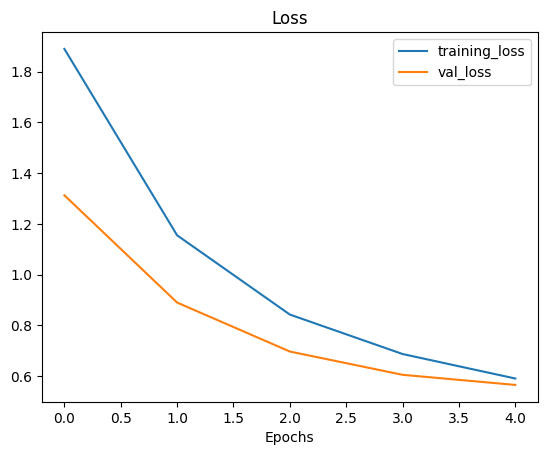

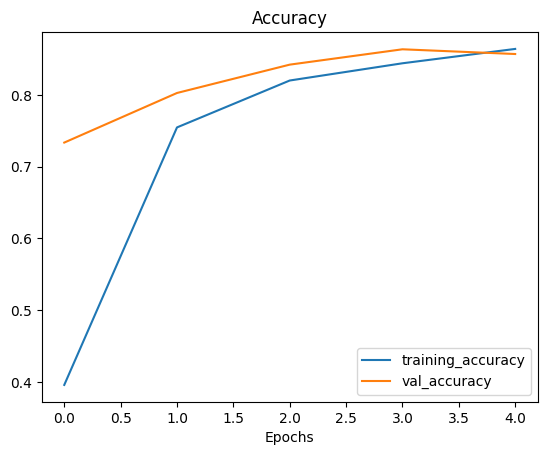

In [21]:
plot_loss_curves(history_0)

In [22]:
model_0.evaluate(test_data)

79/79 [==============================] - 2s 26ms/step - loss: 0.5693 - accuracy: 0.8600


[0.5693420171737671, 0.8600000143051147]

In [23]:
# Check the layer in our basemodel
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [24]:
# How about we get a summary of the base model

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
# How about a summary of our whole model?

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

## Getting a feature vecture from a trained model

Let's demostrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, None, None , 1280)

But when it passes through GlobalAveragePolling2D, it turns int (None, 1280)

Let's user a similar shaped shape tensor of (1, 4,4,3) anf then pass it to GlobalAveragePooling2D.

In [25]:
# Define the input shape

input_shape = (1, 4, 4, 3)

# Create a random tensor

tf.random.set_seed(42)

random_tensor = tf.random.normal(input_shape)

print(f"Random tensor:\n {random_tensor}\n")

# Average pool the random tensor

pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(random_tensor)

print(f"Pooled tensor:\n {pooled_tensor}")

Random tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]


In [26]:
# Check the shape of the diferent tensors

print(f"Random tensor shape: {random_tensor.shape}")
print(f"Pooled tensor shape: {pooled_tensor.shape}")

Random tensor shape: (1, 4, 4, 3)
Pooled tensor shape: (1, 3)


In [27]:
# Let's replicate the Global average pool 2D layer

tf.reduce_mean(random_tensor, axis=[1, 2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

⚒  **Practice: ** Try to do the same with the above cells but this time use `GlobalMaxPool2D`... and see whats happens.

> 🔑 **Note: ** One of the reasons "features extraction transfer learning" is named how it is is beacause what often happens is pretrained model outputs a ** feature vector ** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePolling2D()` layer) which can then be used to extract patterns out of our own specfic problem.

In [28]:
y = tf.keras.layers.GlobalMaxPool2D()(random_tensor)
y

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Runnig a series of fransfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training dta. how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training dtaa augmentation

2. `model_2` - use feature extraction transfer learninig with 10% of the training with data augmentation

3. `model_3` - use fine-tuning on 10% of the training dat with dta augmentation

4. `model_4` - use fine-tuning transfer learning on 100% of the training dta augmentation

> 🔑 **Note:** through all experiments the same test datset will be used to evaluate our model.. this ensures consistency across ecaluation metrics.

In [29]:
# Download and unzip data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-05-25 14:43:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   134MB/s    in 1.0s    

2024-05-25 14:43:26 (134 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [30]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-05-25 14:43:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   306MB/s    in 0.5s    

2024-05-25 14:43:32 (306 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [31]:
# Create trinig and test

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

## Getting and preprocessing dta for model 1

In [32]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
print(tf.__version__)

2.15.0


## Addding data augmentation right to the model

To add augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create dta augmentation stage with horzontal flip, rotation, etc

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

# Visualize or data augmentaiton layer (and seee what happens to our data)

In [35]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
image_path = target_dir + "/" + random_image

In [36]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

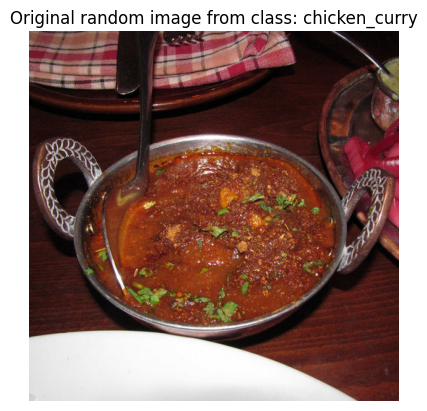

In [37]:
image_grad = mpimg.imread(image_path)
plt.imshow(image_grad)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
plt.show()

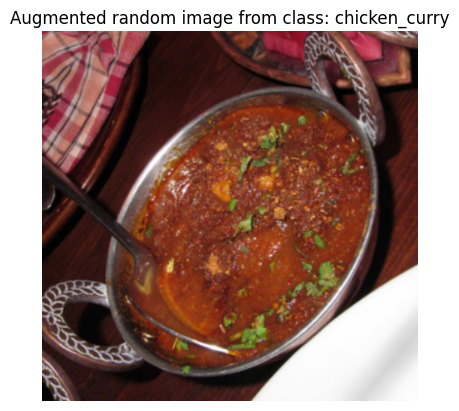

In [39]:
# Now lets plot ou aumented random image

augmented_image = data_augmentation(tf.expand_dims(image_grad, axis=0))
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.show()

## Model 1: feature extraciton transfer learning 1% of the data with data augmentation

In [40]:
# Setup input shape and base model, freezing the base model layer

input_shape = IMAGE_SIZE + (3,)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

In [41]:
# Create input layer

inputs = layers.Input(shape=input_shape, name="input_layer")

In [42]:
# Add in dat augmnetation seguential model as a lyer

x = data_augmentation(inputs)

In [43]:
# Give base_model the inputs (after augmentation) and don't train it

x = base_model(x, training=False)

In [44]:
# Pool output features of the base model

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

In [45]:
# Put a dense layer on as output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

In [46]:
# Create the model 1
model_1 = tf.keras.Model(inputs, outputs)

In [47]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [49]:
history_1_percent = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240525-144446
Epoch 1/5
3/3 [==============================] - 11s 1s/step - loss: 2.3973 - accuracy: 0.0429 - val_loss: 2.2873 - val_accuracy: 0.1086
Epoch 2/5
3/3 [==============================] - 2s 795ms/step - loss: 2.2080 - accuracy: 0.1143 - val_loss: 2.1859 - val_accuracy: 0.1941
Epoch 3/5
3/3 [==============================] - 3s 852ms/step - loss: 2.0437 - accuracy: 0.3286 - val_loss: 2.0773 - val_accuracy: 0.2714
Epoch 4/5
3/3 [==============================] - 2s 797ms/step - loss: 1.8789 - accuracy: 0.4286 - val_loss: 2.0011 - val_accuracy: 0.3026
Epoch 5/5
3/3 [==============================] - 2s 829ms/step - loss: 1.7541 - accuracy: 0.5571 - val_loss: 1.8987 - val_accuracy: 0.3816


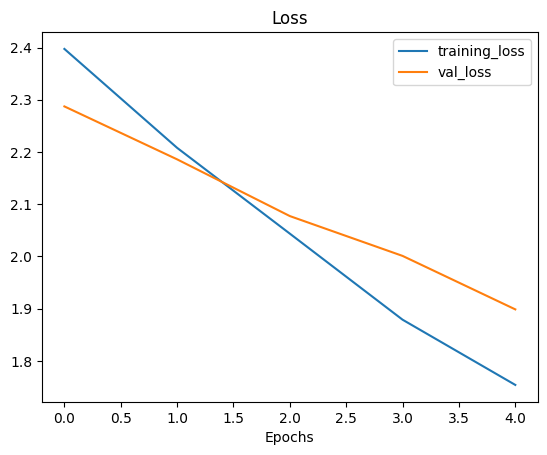

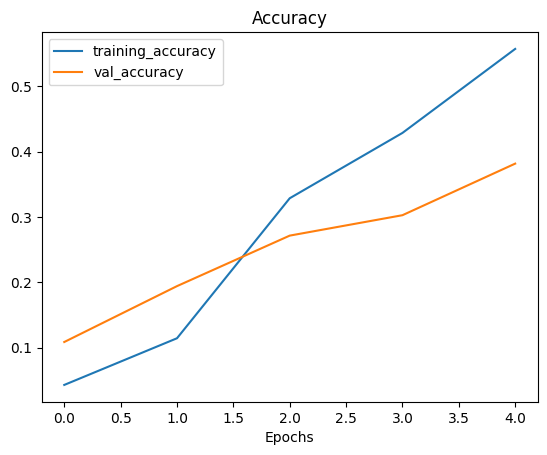

In [50]:
#How do the model 1% of the and data augmentation loss curves look

plot_loss_curves(history_1_percent)

[Data vision 101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

In [51]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 2s 23ms/step - loss: 1.9296 - accuracy: 0.3548


[1.9295917749404907, 0.3547999858856201]

## Model 2: feature extraction transfer learning with 10% of data and data augmentation

In [52]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [53]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [54]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [96]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

# Create dta augmentation stage with horzontal flip, rotation, etc
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

In [97]:
#setup the input shape of our model

input_shape = (224, 224, 3)

In [98]:
# Create a frozen base model (also called the backbone)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

In [99]:
# Create the inputs and the outputs (including the layers in between)

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augemneted images to base model but keep it in inference mode, this also insres batchnorm layers don't updated

In [100]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, None, None, 3)        0         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [101]:
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

In [102]:
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

In [103]:
model_2 = tf.keras.Model(inputs, outputs)

In [104]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [105]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

### Creating a model checkpoint callback

The ModelCheckpoint callback intermediately saves our model (teh full model or just the weights) during trainig. This is useful so we can and start where we left off.

In [106]:
# Set the checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a Modelcheckpoitn call taht saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit mdoel 2 passing in the ModelCheckpointCallback

In [107]:
initial_epochs = 5


In [108]:
model_2_history = model_2.fit(train_data_10_percent,
            epochs=initial_epochs,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[
                checkpoint_callback,
                create_tensorboard_callback("transfer_learning", "10_percent_data_aug")
              ])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240525-154946
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0677 - accuracy: 0.3133
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 776ms/step - loss: 2.0677 - accuracy: 0.3133 - val_loss: 1.5819 - val_accuracy: 0.6217
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4412 - accuracy: 0.6400
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 607ms/step - loss: 1.4412 - accuracy: 0.6400 - val_loss: 1.1300 - val_accuracy: 0.7303
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.7347
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 597ms/step - loss: 1.1281 - accuracy: 0.7347 - val_loss: 0.9112 - val_accuracy: 0.7730
E

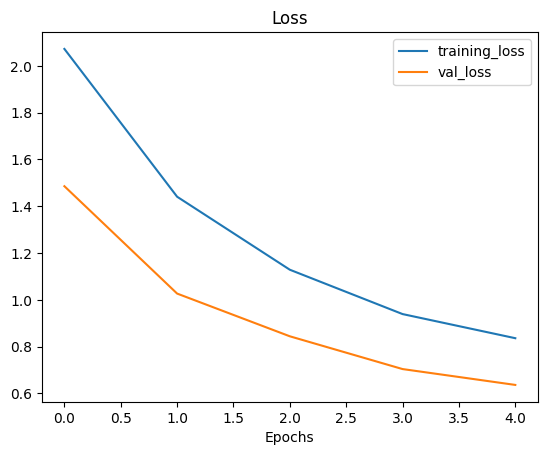

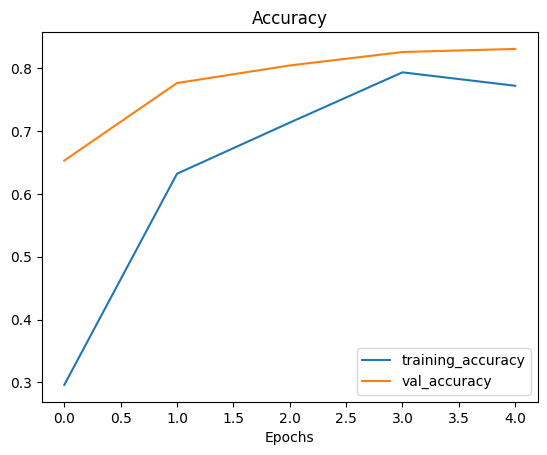

In [68]:
plot_loss_curves(model_2_history)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specifci checkpoint.

In [69]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [70]:
checkpoint_callback

In [71]:
# Evaluate mdoel_2 with laoded weights

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 2s 23ms/step - loss: 0.6522 - accuracy: 0.8312


## Model 3: Fine tuning our existing model 10% of data

> 🔑 **Note: ** Fine-tuning usually work best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [121]:
# layers in loaded model

model_2.layers

In [123]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 False
global_average_pooling_layer True
output_layer True


In [124]:
# What layers are in our base_model and they are trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [75]:
# How many trainable variables are inour base model?

print(len(model_2.layers[2].trainable_variables))

0


In [126]:
# To begin fine-tunin, let's start by setting ou base_model.trainable
base_model.trainable = True

In [127]:
# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),# when fine tuning you typically want to lower the learning rate by 10*%
                metrics=["accuracy"])

> 🔑 **Note: ** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But good rule of thumb is at least 10x (though different sources will claim other values).
A good resource for information on this is the [ULMF paper](https://arxiv.org/abs/1801.06146)

In [128]:
# Checke which layers are tunable (trainable)

for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [80]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [81]:
model_2.trainable_variables

[<tf.Variable 'block6h_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.00207604,  0.01300672,  0.02047416, ..., -0.02240255,
           -0.07708141, -0.00094655],
          [-0.06357138,  0.0959678 , -0.05430871, ..., -0.01352078,
           -0.05987524, -0.11093444],
          [ 0.0068749 , -0.04681807, -0.01513974, ...,  0.03073284,
           -0.01280731,  0.03616464],
          ...,
          [ 0.11381665,  0.00804447, -0.05432149, ...,  0.08015257,
           -0.06561387, -0.05522665],
          [-0.12468243,  0.06938899, -0.07634895, ...,  0.01121222,
           -0.0128268 ,  0.10406019],
          [-0.04722364,  0.10557885,  0.16247186, ...,  0.04582691,
            0.01228108, -0.04941604]]]], dtype=float32)>,
 <tf.Variable 'block6h_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([ 0.04594925,  2.5461788 , -1.426646  , -0.7885664 , -0.24730209,
        -0.5630991 , -0.6161863 , -0.4029834 , -1.4444699 , -1.0481553 ,
        -0.21704195,

In [83]:
# Fine tune for anothe 5 epoch
fined_tune_epochs = initial_epochs + 5

# Refiteh the mdoel (same as model_2 except with more trainable layers)

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=fined_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          initial_epoch=model_2_history.epoch[-1], # start rainaing from the previous last epochs
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240525-152259
Epoch 5/10
24/24 [==============================] - 46s 2s/step - loss: 0.7363 - accuracy: 0.7947 - val_loss: 0.4953 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 25s 1s/step - loss: 0.6089 - accuracy: 0.8187 - val_loss: 0.4808 - val_accuracy: 0.8372
Epoch 7/10
24/24 [==============================] - 27s 1s/step - loss: 0.5455 - accuracy: 0.8213 - val_loss: 0.4632 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 21s 863ms/step - loss: 0.5472 - accuracy: 0.8173 - val_loss: 0.4654 - val_accuracy: 0.8289
Epoch 9/10
24/24 [==============================] - 19s 804ms/step - loss: 0.4939 - accuracy: 0.8533 - val_loss: 0.4198 - val_accuracy: 0.8536
Epoch 10/10
24/24 [==============================] - 18s 751ms/step - loss: 0.4633 - accuracy: 0.8573 - val_loss: 0.4191 - val_accuracy: 0.8503


### Evalute the fine tuning model (model_3 which is actually model_2 fine-tuned for another 5 epochs)

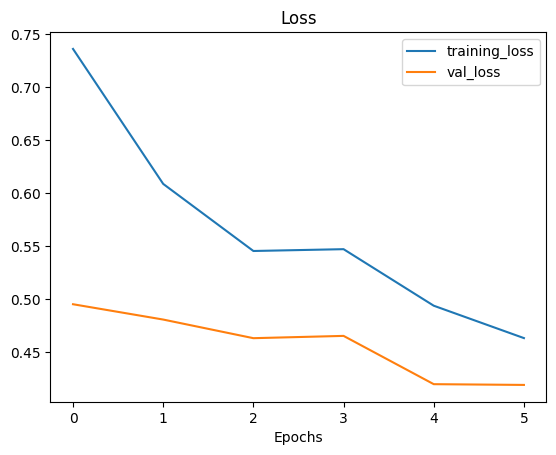

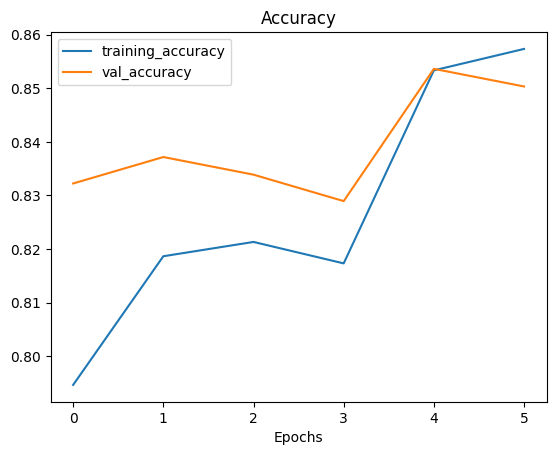

In [84]:
plot_loss_curves(history_10_percent_data_aug)

In [85]:


results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 2s 23ms/step - loss: 0.4359 - accuracy: 0.8516


In [86]:
results_10_percent_data_aug

[0.4359084963798523, 0.8515999913215637]

The `plot_loss_curves` function works great with model whch have only benn fit once, however, we want something to compare one series of runnig `fit()` with another (e.g. before and after fine-tuning).

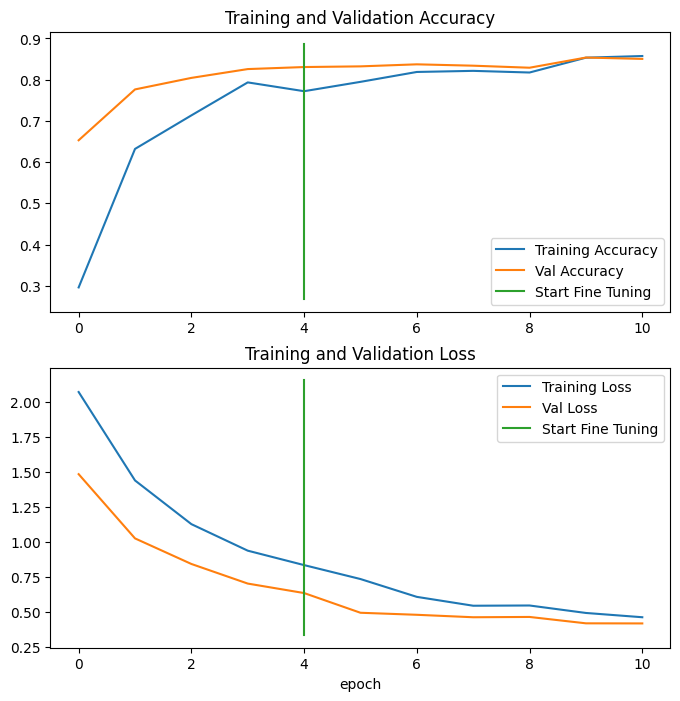

In [87]:
# Let's create a fucntion to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning") # resat the graph to zero
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning") # resat the graph to zero
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("epoch")
  plt.show()

compare_historys(model_2_history, history_10_percent_data_aug, initial_epochs=5)

## Model 4: Fine tunning and existiong model on all of the data set

In [88]:
# Download and unzip 10 classses of Food1010 dta with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-05-25 15:38:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   206MB/s    in 2.4s    

2024-05-25 15:38:45 (206 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [89]:
# Setup training and test directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [90]:
# How many images are we working with now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [91]:
# Setup dat input
import tensorflow as tf
IMAGE_SIZE = (224, 224)

train_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                          label_mode="categorical",
                                                                          image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as waht we've been using for previous experiments (all experiments have used the same test dataset)

Let's verify this...

In [92]:
# Evaluate model 3 (this is teh fine tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 2s 23ms/step - loss: 0.4359 - accuracy: 0.8516


[0.43590855598449707, 0.8515999913215637]

In [93]:
results_10_percent_data_aug

[0.4359084963798523, 0.8515999913215637]

To train a fine-tuning modle model_4 we need ro revert model_2 back to its feature extraction weights.

In [116]:
# Load mdoel from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tune from

model_2.load_weights(checkpoint_path)

In [117]:
# Let's evaluate mdoel 2 now

model_2.evaluate(test_data)

79/79 [==============================] - 5s 23ms/step - loss: 0.6653 - accuracy: 0.8348


[0.6653226613998413, 0.8348000049591064]

Alright, the previous steps seem quite confusing but all we've done is:

1. Trained a feature extration transfer learning model for 5 epochs on 10% of the dta with dta augmentation (model_2) and we saved teh mdoel's weigts using `ModelCheckpoint` callback.

2. Fine-tuned teh same model on the same 10% of the dta for a further 5 epochs with top 10 layers of the base model unfrozen (model_3)

3. Saved the result and training logs each time

4. Reaload the model ffrom step 1 to do the same step by step 2 except this time we're going to use all of the data (model_4)


In [129]:
# Chekc which layer are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [130]:
# Let's drill into our base_model (efficientnetv2-b0) and see what layers are trainable.
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [131]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [132]:
fined_tune_epochs = initial_epochs + 5

model_2_all_dat_history = model_2.fit(train_data_all_data,
            epochs=fined_tune_epochs,
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            initial_epoch=model_2_history.epoch[-1],
            callbacks=[create_tensorboard_callback('transfer_learning', 'full_10_calsses_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_calsses_fine_tune_last_10/20240525-160750
Epoch 5/10
235/235 [==============================] - 154s 614ms/step - loss: 0.7213 - accuracy: 0.7673 - val_loss: 0.4090 - val_accuracy: 0.8717
Epoch 6/10
235/235 [==============================] - 109s 461ms/step - loss: 0.6003 - accuracy: 0.8057 - val_loss: 0.3811 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 95s 403ms/step - loss: 0.5414 - accuracy: 0.8252 - val_loss: 0.3354 - val_accuracy: 0.8980
Epoch 8/10
235/235 [==============================] - 81s 345ms/step - loss: 0.5026 - accuracy: 0.8409 - val_loss: 0.2936 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 75s 318ms/step - loss: 0.4779 - accuracy: 0.8456 - val_loss: 0.3161 - val_accuracy: 0.8964
Epoch 10/10
235/235 [==============================] - 64s 271ms/step - loss: 0.4510 - accuracy: 0.8524 - val_loss: 0.2901 - val_accuracy: 0.9112


In [134]:
# Let's evaluate on all of the test data

results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 2s 24ms/step - loss: 0.2669 - accuracy: 0.9084


In [135]:
results_fine_tune_full_data

[0.26692140102386475, 0.9083999991416931]

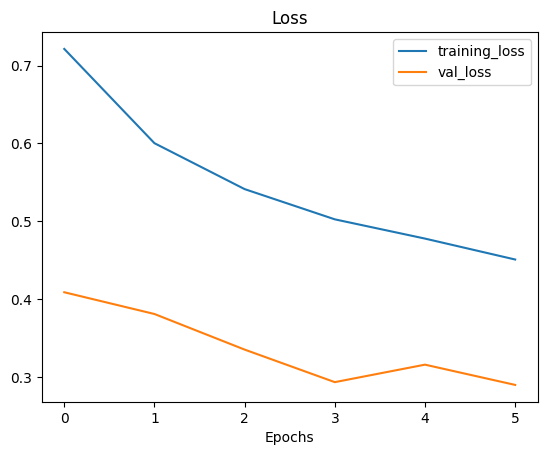

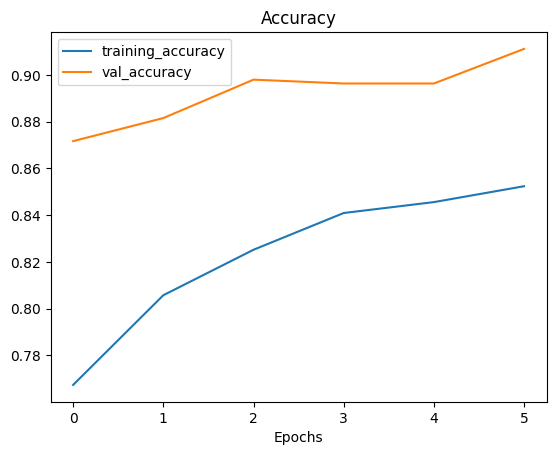

In [136]:
plot_loss_curves(model_2_all_dat_history)

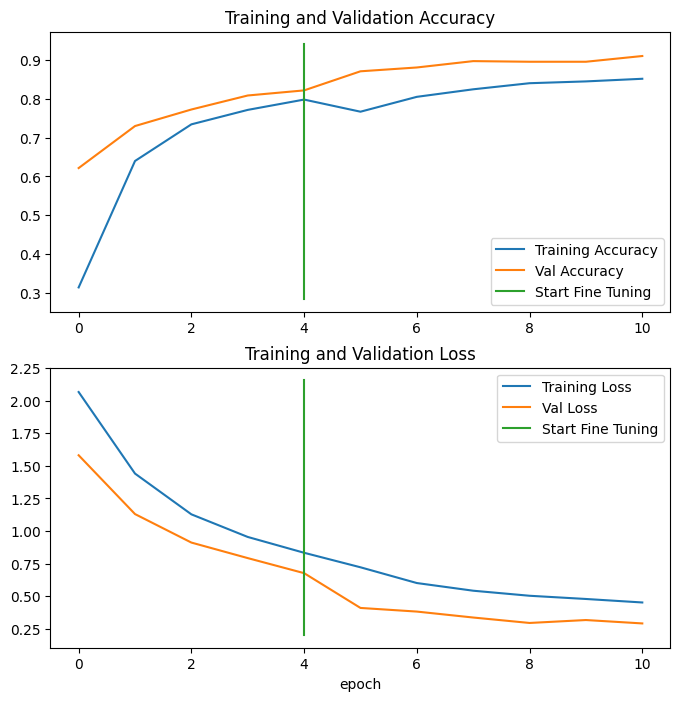

In [138]:
compare_historys(model_2_history, model_2_all_dat_history, initial_epochs=5)